# Part 3: Isolate signal from autofluorescence and noise.

In the following notebook you will use the blank channels to isolate signal.

## 1. Import packages. 
### *This must be done every time the notebook is started or restarted.

In [1]:
from skimage.io import imread, imsave
import os
import numpy as np
import Kview
import stackview
from matplotlib import pyplot as plt
from skimage import filters
from skimage import measure
from skimage import exposure
import pandas as pd
from glob import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import tifffile
current_dateTime = datetime.now()
import warnings
warnings.filterwarnings('ignore')


def ini_params(im1, im2, Pixel_Cutoff:int=0, Blank_Percentile:float=0.0):

    im2_clip = np.clip(im2, Pixel_Cutoff, 65535)
    im2_clip[im2_clip <= Pixel_Cutoff] = 0
    
    im3 = im1 - (np.minimum(im1, im2_clip * Blank_Percentile))
    
    return im3

def find_gauss(im_g1, sigma_value:int=10):

    im_g2 = filters.gaussian(im_g1, sigma=sigma_value, preserve_range=True)
    return im_g2

def clipped_blank(im_cl1, Gauss_low:int = 0, Gauss_high:int = 65535):

    im_cl1[Gauss_low >= im_cl1] = 0  
    im_cl1[im_cl1 >= Gauss_high] = 0

    return im_cl1

def final_factor(im_f1, im_f2, low, high, Gauss_Percentile:float=0.2):

    im_f2[low >= im_f2] = 0  
    im_f2[im_f2 >= high] = 0

    im_f3 = im_f1 - (np.minimum(im_f1, im_f2 * Gauss_Percentile))
    
    return im_f3

## 2. Define directory paths. 
### *This must be done every time the notebook is started or restarted.

In [2]:
base_dir = "C:\\Users\\smith6jt"

In [3]:
reg_dir = os.path.join(base_dir, 'KINTSUGI', 'data', '1904_CC2B_Registration')
sig_dir = reg_dir.replace('_Registration', '_Signal_Isolation')
proc_dir = sig_dir.replace('_Signal_Isolation', '_Processed')
print(f"Registration folder is {reg_dir}.")
print(f"Signal_Isolation folder is {sig_dir}.")
print(f"Processed folder is {proc_dir}.")

Registration folder is C:\Users\smith6jt\KINTSUGI\data\1904_CC2B_Registration.
Signal_Isolation folder is C:\Users\smith6jt\KINTSUGI\data\1904_CC2B_Signal_Isolation.
Processed folder is C:\Users\smith6jt\KINTSUGI\data\1904_CC2B_Processed.


## 3. Write single channel tifs

In [4]:
os.makedirs(sig_dir, exist_ok=True)
os.makedirs(proc_dir, exist_ok=True)
os.makedirs(os.path.join(proc_dir,'Processing_parameters'), exist_ok=True)
os.makedirs(os.path.join(proc_dir,'PostProcessing'), exist_ok=True)

In [22]:
start_cycle = 6
end_cycle = 13
drop_duplicates = True
drop_empty = True
dup_name = 'DAPI'

for j in range(start_cycle, end_cycle + 1):

    ome_tiff_path = os.path.join(reg_dir, "registered", f"cyc{str(j).zfill(2)}.ome.tif") 
    ome_tiff = tifffile.imread(ome_tiff_path)

    with tifffile.TiffFile(ome_tiff_path) as tif:

        xml_description = tif.ome_metadata

    root = ET.fromstring(xml_description)
    namespace = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}

    channel_metadata = {}
    channel_names = []
    for channel in root.findall('.//ome:Channel', namespace):
        channel_name = channel.attrib['Name']
        metadata = {}
        for key, value in channel.attrib.items():
            if key != 'Name':
                metadata[key] = value
        channel_metadata[channel_name] = metadata
        channel_names.append(channel_name)


    for channel_name, metadata in channel_metadata.items():
        channel_index = channel_names.index(channel_name)
        channel_data = ome_tiff[channel_index, ...]
        
        if start_cycle == 1:
            
            channel_image_path = os.path.join(sig_dir, f'{channel_name}.tif')
            imsave(channel_image_path, channel_data, plugin='tifffile', metadata=metadata)

        elif drop_duplicates and channel_name != dup_name:
            if drop_empty and "Empty" not in channel_name:
                channel_image_path = os.path.join(sig_dir, f'{channel_name}.tif')
                imsave(channel_image_path, channel_data, plugin='tifffile', metadata=metadata)


## 4. Determine pixel range and weight of blank channel subtraction.

### 4.1 Instructions

This cell allows the user to choose which blank channel to use (BlankID) and determine how much, if any, blank image to subtract(Blank_Percentile).  It also allows for only subtracting a range of pixel values (Pixel_Cutoff).  Use these values in the next cell.
For each marker, enter the name of the image file without the extension for signal_channel.

Change 'bl_CH' to a, b, or c according to the channel that marker was imaged on i.e. if marker is CH3, the last letter of both blanks should be 'b', CH4 should be 'c'.  For far-red channels (700nm+), the blank channels often do not match the background autofluorescence well.  If this is the case, a suitable 'b' or 'c' blank should be chosen instead.

Change 'bl_int' to 1 or 13 according to the blank cycle.  Blank 13 generally has photobleached autofluorescent signal compared with Blank 1, and generally removes more diffuse background.  Sometimes the images from cycles earlier in the run will match closer to blank1 while those later will match closer to blank13.

Sometimes blurring before subtraction can help.  Uncomment to apply to either the blank or signal image.  Adjust sigma to control radius(strength) of blurring.

The first Kview.interact function is for viewing the effects of subtraction on a cropped portion of the image.  Adjust coordinates to determine the size.  The second is for viewing the whole image.  

To assess subtraction, first slowly move the Blank_Percentile slider while noting if autofluorescent structures only are getting dimmer.  Continue until none of these remain while noting if marker signal is being diminished.  Then, slowly move the other slider until signal is brightest without reintroducing autofluorescence/noise.  Once values of Blank_Percentile and Pixel_Cutoff are found, use them for the next Kview.interact to see how they look on the entire image.

Note that these cells are meant to be rerun multiple times if necessary.

### 4.2 First Round

In [4]:
signal_channel = 'CD44'
bl_CH = 'b'
bl_int = 1

params_filename = os.path.join(proc_dir, 'Processing_parameters', f'{signal_channel}_param.txt')
signal_image_tiff = imread(os.path.join(sig_dir, f'{signal_channel}.tif'))
blankID = f'Blank{str(bl_int)}{bl_CH}'
blank_image_tiff = imread(os.path.join(sig_dir, f'{blankID}.tif'))

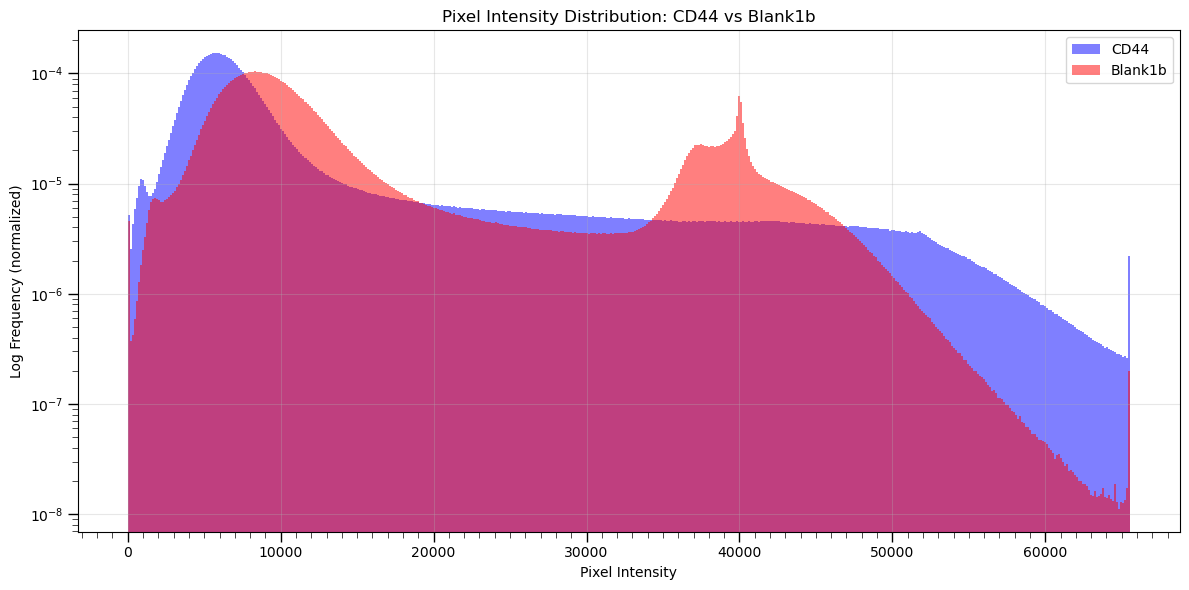

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

bins = np.linspace(0, 65535, 500)
ax.hist(signal_image_tiff.ravel(), bins=bins, alpha=0.5, label=signal_channel, 
            density=True, color='blue', range=(0, 65535))
ax.hist(blank_image_tiff.ravel(), bins=bins, alpha=0.5, label=blankID,
            density=True, color='red', range=(0, 65535))

ax.set_yscale('log')
ax.set_xlabel('Pixel Intensity')
ax.minorticks_on()
ax.tick_params(which='minor', length=4, width=0.5)
ax.tick_params(which='major', length=7, width=1)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1000)) 
ax.set_ylabel('Log Frequency (normalized)')
ax.set_title(f'Pixel Intensity Distribution: {signal_channel} vs {blankID}')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()

In [6]:
print(f"Working with: {signal_channel} and {blankID}. Pixel min, max: {np.min(signal_image_tiff)}, {np.max(signal_image_tiff)}")

# blank_image_tiff = filters.gaussian(blank_image_tiff, sigma=3, preserve_range=True)

x1 = 2000
x2 = 5000
y1 = 3000
y2 = 6000

# Adjust zoom_factor to fit the image to your screen.  The other values can be adjusted as needed.
Kview.interact(ini_params, signal_image_tiff[y1:y2, x1:x2], blank_image_tiff[y1:y2, x1:x2], zoom_factor=0.3, colormap = 'turbo', min_value=0, max_value=65535, step=1000)

Working with: CD44 and Blank1b. Pixel min, max: 0, 65535


In [69]:
print(f"Working with: {signal_channel} and {blankID}. Pixel min, max: {np.min(signal_image_tiff)}, {np.max(signal_image_tiff)}")
Kview.interact(ini_params, signal_image_tiff, blank_image_tiff, zoom_factor=0.1, colormap = 'turbo', min_value=0, max_value=65535, step=1000)

Working with: CD31 and Blank1b. Pixel min, max: 0, 65535


This cell performs the subtraction with values determined above.
If no subtraction was necessary, enter 0 for both and then go to 6. to visualize and save.

In [72]:
# Enter Pixel_Cutoff from above:
blank_clip_factor = 0

# Enter Blank_Percentile from above:
background_scale_factor = 0.2
# blank_image_tiff = filters.gaussian(blank_image_tiff, sigma=3, preserve_range=True)
blank_image = np.clip(blank_image_tiff, blank_clip_factor, blank_image_tiff.max())
blank_image[blank_image <= blank_clip_factor] = 0

signal_image = signal_image_tiff - (np.minimum(signal_image_tiff, blank_image * background_scale_factor))

### 4.3 Second Round

If desired the process can be repeated with the same or another blank channel to get satisfactory results. 

In [67]:
bl_CH2 = 'b'
bl_int2 = 13

blankID2 = f'Blank{str(bl_int)}{bl_CH}'
blank_image_tiff_2 = imread(os.path.join(sig_dir, f'{blankID2}.tif'))
# blank_image_tiff_2 = filters.gaussian(blank_image_tiff_2, sigma=1, preserve_range=True)

print(f"Working with: {signal_channel} and {blankID2}. Pixel min, max: {np.min(signal_image_tiff)}, {np.max(signal_image_tiff)}")

x1 = 3000
x2 = 5000
y1 = 5000
y2 = 7000

Kview.interact(ini_params, signal_image[y1:y2, x1:x2], blank_image_tiff_2[y1:y2, x1:x2], zoom_factor=0.3, colormap = 'turbo', min_value=0, max_value=65535, step=1000)

Working with: CD31 and Blank1b. Pixel min, max: 0, 65535


In [68]:
print(f"Working with: {signal_channel} and {blankID2}. Pixel min, max: {np.min(signal_image_tiff)}, {np.max(signal_image_tiff)}")
Kview.interact(ini_params, signal_image, blank_image_tiff_2, zoom_factor=0.1, colormap = 'turbo', min_value=0, max_value=65535, step=1000)

Working with: CD31 and Blank1b. Pixel min, max: 0, 65535


In [7]:
blank_clip_factor_2 = 0
background_scale_factor_2 = 0.7
blank_image_2 = np.clip(blank_image_tiff_2, blank_clip_factor_2, blank_image_tiff_2.max())
blank_image_2[blank_image_2 <= blank_clip_factor_2] = 0
signal_image = signal_image - (np.minimum(signal_image, blank_image_2 * background_scale_factor_2))

## 5. Gaussian Subtraction

### 5.1 Determine Sigma

If no other changes need to be made, go to Section 6 and save.

If there are patterns such as those with right angles that don't represent biological variation, this section derives the pattern pixels for subtraction by creating a blurred version of the image, determining which pixels to clip, and then determining the weight of subtraction.  

This Kview.interact function helps to find the optimal sigma value for blurring.

In [71]:
# Higher sigma_values take longer to process.
Kview.interact(find_gauss, signal_image, zoom_factor=0.1, colormap = 'turbo', min_value=0, max_value=60, step=5)

Enter the sigma value to control the degree of blurring.

In [8]:
sigma = 20
signal_gauss = filters.gaussian(signal_image, sigma=sigma, preserve_range=True)
signal_gauss = exposure.match_histograms(signal_gauss, signal_image, multichannel=False)

### 5.2 Determine Pixel Range

Apply a range of pixel values to the gaussian subtraction by clipping low and/or high pixels from the blurred signal image that will be subtracted from the original signal image.  Run after performing the gaussian blur in the cell above.  

Raising the Gauss_low value will eliminate the dimmer pixel values from the blurred image, resulting in more of the dimmer signal being preserved in the final processed image.  

Lowering the Gauss_high value will eliminate the brighter pixel values from the blurred image, resulting in more of the brighter signal being preserved in the final processed image.

Comment/uncomment the lines to view cropped and full views of the blurred image.

In [ ]:
# Kview.interact(clipped_blank, signal_gauss[x1:x2,y1:y2], zoom_factor=0.5, colormap = 'viridis', continuous_update=True, display_min = 0, display_max = np.max(signal_gauss), min_value=0, max_value=np.max(signal_gauss), step=100)

Kview.interact(clipped_blank, signal_gauss, zoom_factor=0.07, colormap = 'viridis', continuous_update=True, display_min = 0, display_max = np.max(signal_gauss), min_value=0, max_value=np.max(signal_gauss), step=100)

### 5.3 Determine Weight

Determine how much subtraction to do, similar to Blank_Percentile in Section 4.  Enter the Gauss_Cutoff values from the cell above.

In [ ]:
Gauss_low = 10800
Gauss_high = 44789

Kview.interact(final_factor, signal_image, signal_gauss, Gauss_low, Gauss_high, colormap = 'viridis', display_max = np.max(signal_gauss), zoom_factor=0.07)

# Kview.interact(final_factor, signal_image[x1:x2,y1:y2], signal_gauss[x1:x2,y1:y2], Gauss_low, Gauss_high, colormap = 'viridis', display_max = np.max(signal_gauss), zoom_factor=.07)

### 5.4 Perform Subtraction

Performs the gaussian subtraction.  Enter the value determined from the previous cell.

In [10]:
g_low = Gauss_low
g_high = Gauss_high
gauss_weight = 0.2

signal_gauss[g_low >= signal_gauss] = 0  
signal_gauss[signal_gauss >= g_high] = 0

signal_image_final = signal_image - (np.minimum(signal_image, signal_gauss * gauss_weight))

## 6. View Results

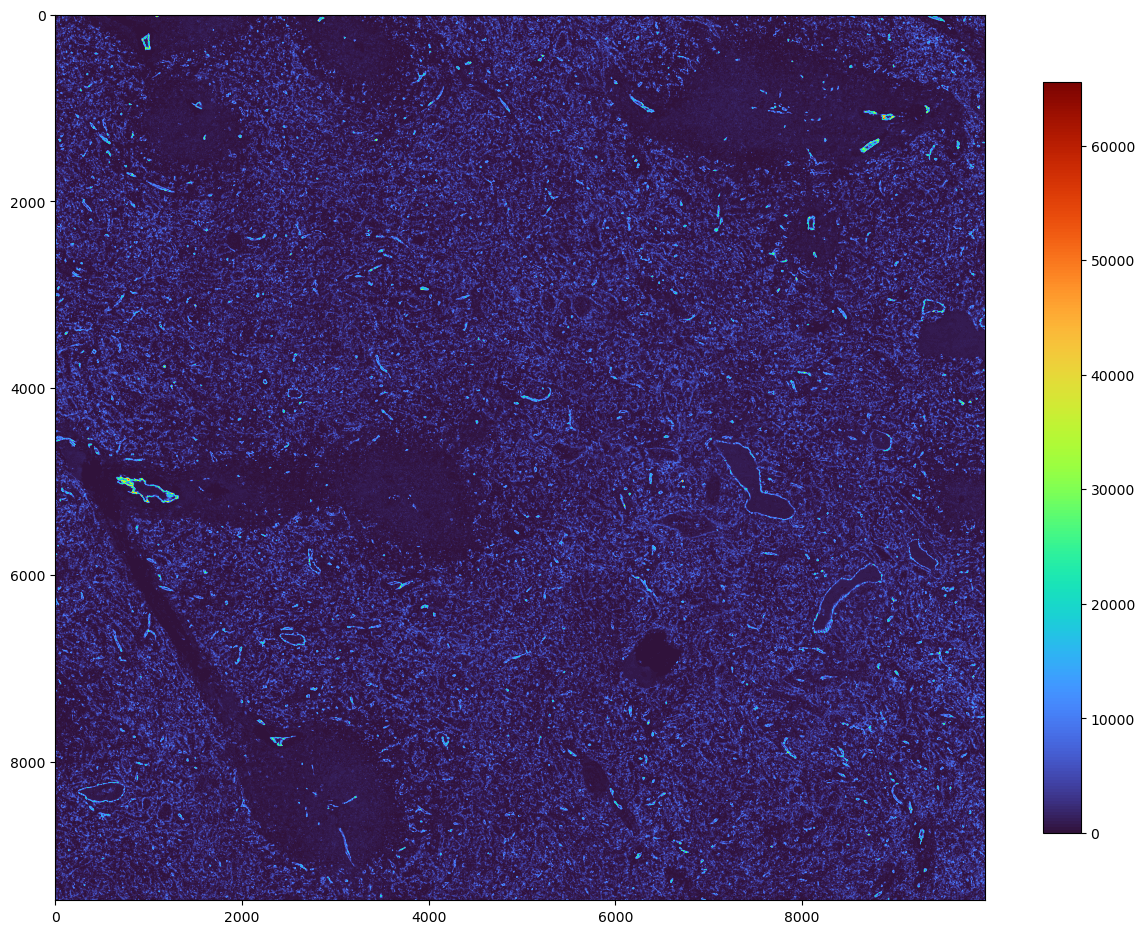

In [74]:
# Note that if no changes were made after initial subtraction, you must change signal_image_final to signal_image.
signal_image_final = signal_image
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
im = axes.imshow(signal_image_final, cmap='turbo')
fig.colorbar(im, ax=axes, shrink=.65)
plt.show()

In [77]:
x1 = 3000
x2 = 3500
y1 = 4000
y2 = 4500
stackview.curtain(signal_image_tiff[x1:x2,y1:y2], signal_image_final[x1:x2,y1:y2], alpha=1, zoom_factor=1.5, colormap = 'turbo', curtain_colormap='magma')

In [ ]:
stackview.animate_curtain(signal_image_tiff[x1:x2,y1:y2], signal_image_final[x1:x2,y1:y2], zoom_factor=1.5, colormap = 'turbo', curtain_colormap='magma', filename=os.path.join(base_dir, 'KINTSUGI', 'docs', f'{signal_channel}_curtain.gif'), frame_delay_ms=500, num_loops=10)

## 6. Post Processing

Move your mouse around the output of the following cell to assess background levels.  Areas with no signal should be zero.  Find the highest background values to subtract from the entire image.

In [80]:
stackview.picker(signal_image_final[x1:x2,y1:y2], colormap='turbo', zoom_factor=1.5)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(signal_image_final, name='signal_image_final', colormap='turbo')

## 7. Save Image and Parameters

Even with this process, it may be that certain markers should be excluded.  Manually create a "failed markers" file to list these and save it in the 'Processing_parameters' folder.

This cell saves the image and the parameters used.  The next steps in FIJI should be saved using Plugins>Macros>Record to record all steps. Copy/paste to append to the params file.


In [39]:
Notes = '''
Here you can add any notes you want to save with the processing parameters.
'''
variables = globals()
variable_names_to_save = ['current_dateTime',
                           'signal_channel', 
                           'blankID', 
                           'blank_clip_factor', 
                           'background_scale_factor', 
                           'blankID2', 
                           'blank_clip_factor_2', 
                           'background_scale_factor_2', 
                           'sigma', 
                           'g_low', 
                           'g_high', 
                           's_image_factor',
                           'blank_factor', 
                           'Notes']

with open(params_filename, 'w') as file:
    for var_name in variable_names_to_save:
        if var_name in variables:
            var_value = variables[var_name]
            var_str = f'{var_name}: {repr(var_value)}\n'
            file.write(var_str)

imsave(os.path.join(proc_dir, f'{signal_channel}.tif'), signal_image)

## 7. Auxiliary Functions

Merge all the images together.

In [7]:
sample_id = '1904_CC2B'
pixelsize = 0.3774
channel_names = []
file_list = glob(os.path.join(proc_dir,'*.tif'))
for file in file_list:

    file_name = os.path.basename(file)
    channel_name = file_name.split('.')[0]
    channel_names.append(channel_name)

image = imread(file_list).astype(np.uint8)

imsave(os.path.join(proc_dir,f'{sample_id}.tif'), image, imagej=True, resolution=(1/pixelsize, 1/pixelsize), resolutionunit='micron', metadata={'axes': 'CYX', 'Labels': channel_names})

This function may be used in place of ini_params above to assess how subtraction affects signal to noise.  Must have a binary segmentation file.

In [ ]:
def ini_params_SNR(images, imageb, seg_mask, blclfa:int=0, bckscfa:float=.0):

    blank_image = np.clip(imageb, blclfa, 65535)
    blank_image[blank_image <= blclfa] = 0

    signal_image = images - (np.minimum(images, blank_image * bckscfa))
    seg_mask = measure.label(seg_mask, return_num=True, background=0)
    properties = measure.regionprops(seg_mask[0], intensity_image=signal_image)
    statistics = {
   
    'area':       [p.area               for p in properties if p.area<800],
    'mean':       [p.mean_intensity     for p in properties if p.area<800]
    }
    df = pd.DataFrame(statistics)
    
    MFI = np.asarray(df['mean'])
    aX = MFI.flatten()
    # compute 20 largest values in aX
    top20 = np.sort(aX)[-20:]
    # compute the mean of bottom 10th percentile of aX
    btm10 = np.sort(aX)[:int(len(aX)*0.1)]
    top20btm10 = np.mean(top20)/np.mean(btm10)
    
    print('SNR is ' + str(top20btm10)) 
    print(df.describe())
    return signal_image

In [ ]:
Kview.interact(ini_params_SNR, signal_image, blank_image_tiff_2, zoom_factor=0.1, colormap = 'viridis', min_value=0, max_value=50000, step=1000)